# LCS KDA Predictor

```
LCS KDA Predictor
Authors: Jeffrey Garrett, Jesse Krepelka

https://oracleselixir.com/stats/players/byTournament/(TournamentSpecifics)
```






In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Helper Functions

In [2]:
def plot_actual_predicted(actual, predicted, title):
    a = [actual.min(), actual.max()]
    b = [predicted.min(), predicted.max()]
    sns.scatterplot(actual,predicted)
    plt.plot(a, b,'--k')
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

# Importing Data

Made a common index for player

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2015_Sp.csv')

dataFiles = ['https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2015_Su.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2016_Sp.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2016_Su.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2017_Sp.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2017_Su.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2018_Sp.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2018_Su.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2019_Sp.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2019_Su.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2020_Sp.csv',
             'https://raw.githubusercontent.com/JeffreyGarrett/lolData/main/LCS_2020_Su.csv']

for url in dataFiles:
    df = df.append(pd.read_csv(url))

# Preprocessing


converting non-numeric values to numeric values

In [4]:
df['W%'] = df['W%'].str.replace('%','')
df['KP'] = df['KP'].str.replace('%','')
df['KS%'] = df['KS%'].str.replace('%','')
df['DTH%'] = df['DTH%'].str.replace('%','')
df['FB%'] = df['FB%'].str.replace('%','')
df['CS%P15'] = df['CS%P15'].str.replace('%','')
df['DMG%'] = df['DMG%'].str.replace('%','')
df['GOLD%'] = df['GOLD%'].str.replace('%','')
df['W%'] = pd.to_numeric(df['W%'])
df['KP'] = pd.to_numeric(df['KP'])
df['KS%'] = pd.to_numeric(df['KS%'])
df['DTH%'] = pd.to_numeric(df['DTH%'])
df['FB%'] = pd.to_numeric(df['FB%'])
df['CS%P15'] = pd.to_numeric(df['CS%P15'])
df['DMG%'] = pd.to_numeric(df['DMG%'])
df['GOLD%'] = pd.to_numeric(df['GOLD%'])

*   Dropping incomplete data
*   Dropping all players with less than 6 games played (per position per split)
*   Converting positon played to numerical values.

In [5]:
df.drop(['CTR%'], axis=1, inplace=True)
df = df[df['GP']>=6]
df['Pos'] = df.Pos.map(dict(Support=1, ADC=2, Middle=3, Jungle=4, Top=5))

# Exploration of data




Both info and describe for inspection. 

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 0 to 66
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  665 non-null    object 
 1   Team    665 non-null    object 
 2   Pos     665 non-null    int64  
 3   GP      665 non-null    int64  
 4   W%      665 non-null    int64  
 5   K       665 non-null    int64  
 6   D       665 non-null    int64  
 7   A       665 non-null    int64  
 8   KDA     665 non-null    float64
 9   KP      665 non-null    float64
 10  KS%     665 non-null    float64
 11  DTH%    665 non-null    float64
 12  FB%     665 non-null    int64  
 13  GD10    665 non-null    int64  
 14  XPD10   665 non-null    int64  
 15  CSD10   665 non-null    float64
 16  CSPM    665 non-null    float64
 17  CS%P15  665 non-null    float64
 18  DPM     665 non-null    int64  
 19  DMG%    665 non-null    float64
 20  EGPM    665 non-null    int64  
 21  GOLD%   665 non-null    float64
 22  WPM

,Pos,GP,W%,K,D,A,KDA,KP,KS%,DTH%,FB%,GD10,XPD10,CSD10,CSPM,CS%P15,DPM,DMG%,EGPM,GOLD%,WPM,WCPM
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000
mean,3.001504,22.082707,49.190977,53.233083,52.846617,129.064662,3.720902,68.767669,19.804211,20.096992,25.681203,-5.860150,-4.700752,-0.182556,6.197594,19.900752,366.052632,19.901955,219.196992,19.948421,0.668737,0.265173
std,1.406203,11.491645,18.529639,43.831875,33.197664,82.658521,1.605459,6.407659,9.459251,4.255028,13.250052,134.175348,149.621820,4.188078,3.094913,10.105248,161.715312,8.457444,63.317297,5.639328,0.389644,0.109503
min,1.000000,6.000000,0.000000,1.000000,6.000000,15.000000,0.800000,43.800000,0.900000,7.900000,0.000000,-669.000000,-521.000000,-15.800000,0.500000,1.700000,80.000000,4.200000,77.000000,7.400000,0.080000,0.050000
25%,2.000000,16.000000,35.000000,22.000000,31.000000,75.000000,2.700000,65.200000,12.900000,17.100000,17.000000,-82.000000,-92.000000,-2.800000,4.000000,12.300000,212.000000,11.800000,175.000000,16.600000,0.420000,0.170000
50%,3.000000,18.000000,50.000000,42.000000,42.000000,102.000000,3.400000,69.200000,20.600000,20.200000,24.000000,-8.000000,-5.000000,-0.200000,7.600000,24.500000,382.000000,21.200000,233.000000,21.400000,0.510000,0.260000
75%,4.000000,20.000000,63.000000,67.000000,61.000000,160.000000,4.300000,73.200000,27.000000,22.800000,33.000000,76.000000,73.000000,2.200000,8.700000,28.000000,497.000000,27.100000,271.000000,24.400000,0.810000,0.340000
max,5.000000,51.000000,94.000000,256.000000,173.000000,458.000000,14.200000,89.000000,43.500000,37.800000,78.000000,370.000000,549.000000,13.100000,10.700000,36.600000,756.000000,42.500000,342.000000,29.600000,1.770000,0.600000


First we explored what we thought were likely correlated stats.

Text(0.5, 1.0, 'Likelyhood of winning game vs Getting first kill of game')

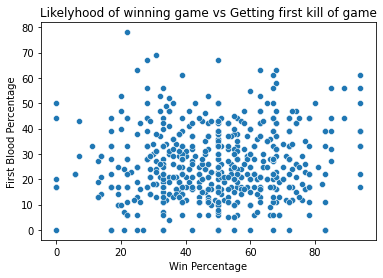

In [7]:
ax = sns.scatterplot(x='W%',y='FB%',data=df)
ax.set_xlabel('Win Percentage') 
ax.set_ylabel('First Blood Percentage')
ax.set_title('Likelyhood of winning game vs Getting first kill of game')

Deviation from the standard of DMG% as a function of GOLD% should indicate greater value. Mostly just grouped by position.

Text(0.5, 1.0, 'Damage as a function of income')

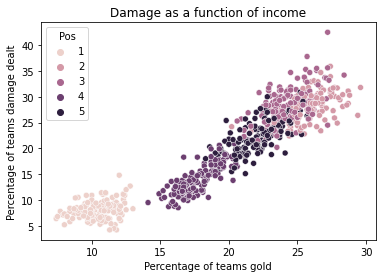

In [8]:
ax = sns.scatterplot(x='GOLD%',y='DMG%',data=df, hue='Pos')
ax.set_xlabel('Percentage of teams gold')
ax.set_ylabel('Percentage of teams damage dealt')
ax.set_title('Damage as a function of income')

Comparison of win percentage to several early game stats.

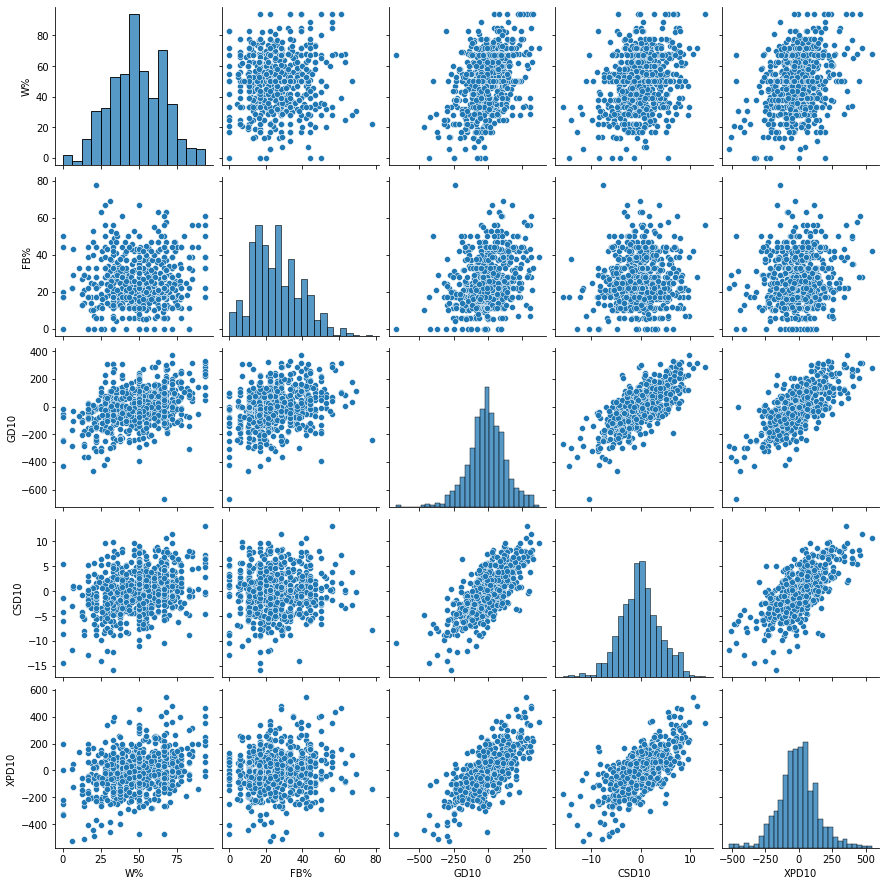

In [9]:
pf = df[['W%','FB%', 'GD10','CSD10','XPD10']]
sns.pairplot(pf)
plt.show()

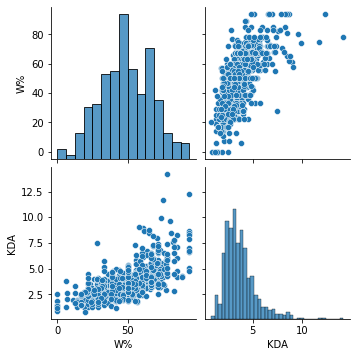

In [10]:
pf = df[['W%','KDA']]
sns.pairplot(pf)
plt.show()

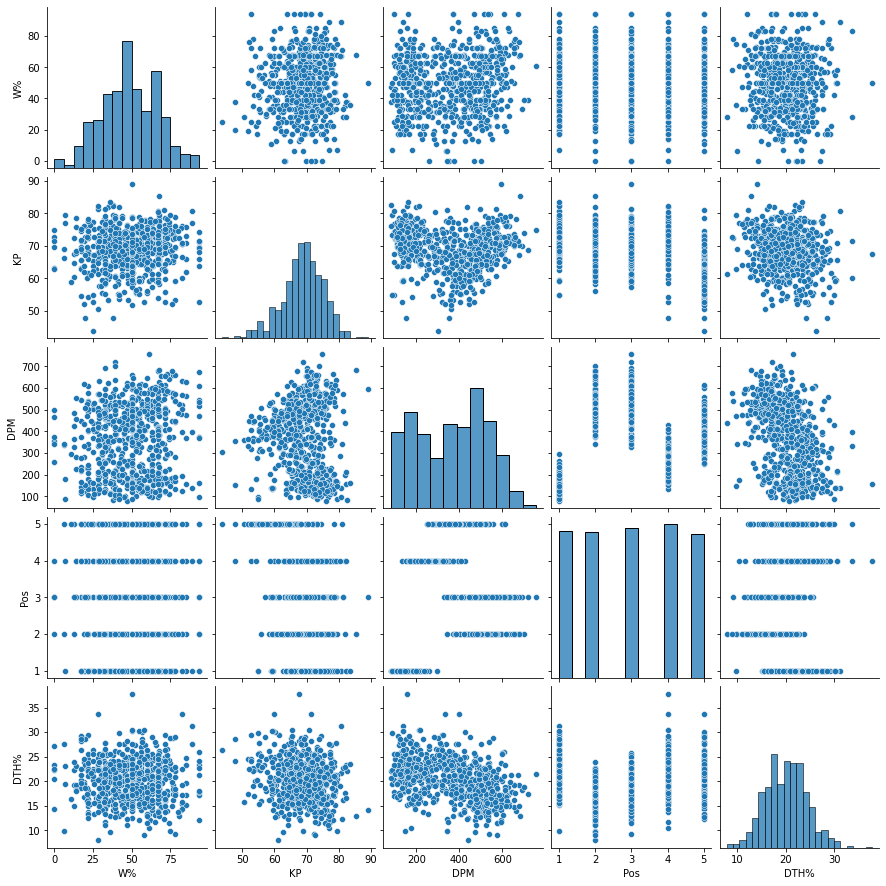

In [11]:
pf = df[['W%', 'KP', 'DPM', 'Pos', 'DTH%' ]]
sns.pairplot(pf)
plt.show()

# Predictions

After some tinkering we determined that using win percentage, individual kill participation, damage per minute, and which position you played we could somewhat accurately predict a players KDA(Kill/Death/Assist) Form: (Kills + Assists) / Deaths

In [13]:
predictors = ['W%', 'KP', 'DPM', 'Pos','DTH%']
x = df[predictors].values
y = df['KDA']

#initial model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
reg = LinearRegression()
reg.fit(x_train, y_train)

print('intercept: {:.2f}'.format(reg.intercept_))
print('Mmin: {:.3f}'.format(reg.coef_[0]))
#print('Mmax: {:.3f}'.format(reg.coef_[1]))

r2 = reg.score(x, y)
print('R-squared: {:.2f}'.format(r2))
predicted = reg.predict(x_test)
RMSE = np.sqrt(((y_test-predicted)**2).mean())
print('RMSE: {:.2f}'.format(RMSE))

intercept: 1.75
Mmin: 0.055
R-squared: 0.80
RMSE: 0.66


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


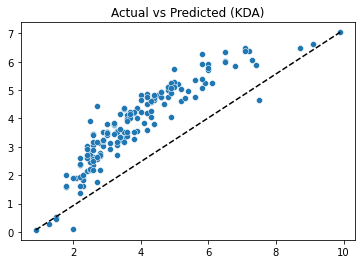

In [14]:
plot_actual_predicted(y_test, predicted, 'Actual vs Predicted (KDA)')

The same data with Polynomial Features explored.

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(x)
X_poly = poly.transform(x)

x_train, x_test, y_train, y_test = train_test_split(X_poly, y, test_size=.20, random_state=0)
regp = LinearRegression()
regp.fit(x_train, y_train)
predict = regp.predict(x_test)

print('intercept: {:.2f}'.format(regp.intercept_))
print('Mmin: {:.3f}'.format(regp.coef_[0]))
#print('Mmax: {:.3f}'.format(reg.coef_[1]))

print('r-squared value of regs: {:.4f}'.format(regp.score(x_train,y_train)))
RMSE = np.sqrt(((y_test-predict)**2).mean())
print(RMSE)

intercept: 0.91
Mmin: 0.017
r-squared value of regs: 0.9084
0.5036906265261962


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


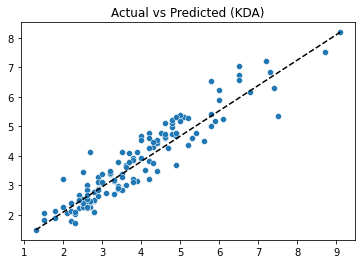

In [16]:
plot_actual_predicted(y_test, regp.predict(x_test), 'Actual vs Predicted (KDA)')

# Test


Apply prediction model to newer data to ensure real correlation.
```
Provided input (Vulcan from Cloud9 season 2021 as of 2/26/2021)
    W% = 78
    KP = 62
   DPM = 165
   Pos = 1
  DTH% = 30.3
Expected Output:
   KDA = 2.9
```

In [26]:
p = np.array(np.mat('78 62 165 1 30.3'))
p_poly = poly.transform(p)
print('Predicted KDA = {:.3f}'.format(regp.predict(p_poly)[0]))

Predicted KDA = 2.897
